In [34]:
from xgboost import XGBRegressor
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, make_scorer
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import numpy as np
import matplotlib.pyplot as plt
import json
from joblib import dump

In [35]:

dataset_path = r"C:\Users\vivia\co-pilot-v1\data\processed_data\parts_data.feather" 
df = pd.read_feather(dataset_path)


In [37]:

# Select the features (X) and target (y) for modeling
# Select the features (X) and target (y) for modeling
feature_cols = [col for col in df.columns if col not in {'part_number', 'description', 'supplier_name',
                                                         'sales_last_jan','sales_last_feb', 'sales_last_mar', 'sales_last_apr', 'sales_last_may',
                                                         'sales_last_jun', 'sales_last_jul', 'sales_last_aug', 'sales_last_sep',
                                                         'sales_last_oct', 'sales_last_nov', 'sales_last_dec', 'sales_jan',
                                                         'sales_feb', 'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 
                                                         'sales_jul', 'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 
                                                         'sales_dec', 'sales_this_year', 'sales_last_year', 'sales_revenue',
                                                         'price', 'sales_to_stock_ratio', 'rolling_12_month_sales', 'cogs',
                                                         'margin', 'quantity', 'demand'}]
X = df[feature_cols]
y = df['rolling_12_month_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
print(X.columns)


Index(['months_no_sale', 'quantity_ordered_ytd', 'special_orders_ytd',
       'negative_on_hand', 'rolling_3_month_sales', 'cost_per_unit',
       'total_cost', 'margin_percentage', 'gross_profit', 'roi',
       'annual_days_supply', 'three_month_days_supply',
       'one_month_days_supply', 'annual_turnover', 'three_month_turnover',
       'one_month_turnover', 'order_to_sales_ratio', 'seasonal_component',
       'safety_stock', 'reorder_point'],
      dtype='object')


In [11]:

# Define preprocessing pipeline
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', RobustScaler()),
            ('power_trans', PowerTransformer(method='yeo-johnson'))]),
        numerical_features)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [12]:

# Define space for Hyperopt
space = {
    'objective': 'reg:pseudohubererror',
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1.0),
    'gamma': hp.uniform('gamma', 0.25, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.05)),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 3, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 350, 750, 10),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(3)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'max_delta_step': hp.quniform('max_delta_step', 5, 10, 1),
    'huber_slope': hp.uniform('huber_slope', 0.2, 0.3),
}


In [13]:

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [14]:

# Set up the scoring function for cross-validation
msle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['max_delta_step'] = int(params['max_delta_step']) 
    
    model = XGBRegressor(**params)
    # Store the scores for each fold
    scores = cross_val_score(model, X_train_transformed, y_train, scoring='neg_mean_absolute_error', cv=5)
    return {'loss': -scores.mean(), 'status': STATUS_OK}


In [15]:

# Run the optimization
trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=500, trials=trials)

print("Best Hyperparameters:", best_hyperparams)


100%|██████████| 500/500 [14:19<00:00,  1.72s/trial, best loss: 0.513067202218923] 
Best Hyperparameters: {'colsample_bytree': 0.941599993761106, 'gamma': 0.2794059456028195, 'huber_slope': 0.2999415578976761, 'learning_rate': 0.048035239601991755, 'max_delta_step': 5.0, 'max_depth': 14.0, 'min_child_weight': 3.0, 'n_estimators': 620.0, 'reg_alpha': 0.005248444802271943, 'reg_lambda': 1.4151121870839436, 'subsample': 0.9289372561562756}


In [16]:

# Correctly casting the best hyperparameters to their correct types
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['max_delta_step'] = int(best_hyperparams['max_delta_step'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])

In [17]:

# Train the model with the best hyperparameters
model = XGBRegressor(**best_hyperparams)

rfecv = RFECV(estimator=model, step=1, cv=KFold(10), scoring='neg_mean_absolute_error')


In [18]:

# Fit RFE
rfecv.fit(X_train_transformed, y_train)

selected_features_mask = rfecv.support_

c:\Users\vivia\co-pilot-v1\myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "huber_slope" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\vivia\co-pilot-v1\myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "huber_slope" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\vivia\co-pilot-v1\myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "huber_slope" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\vivia\co-pilot-v1\myenv\Lib\

In [19]:

# Get the ranking of the features
feature_ranking = rfecv.ranking_

# Get the selected features from your preprocessor
selected_features = [feature for feature, selected in zip(numerical_features, selected_features_mask) if selected]

# Print the optimal number of features
print(f"Optimal number of features: {rfecv.n_features_}")


Optimal number of features: 14


In [24]:
# Save the selected features and the best hyperparameters to a JSON file
results_dict = {
    "selected_features": selected_features,
    "best_hyperparameters": best_hyperparams
}

general_model_path = r"C:\Users\vivia\co-pilot-v1\Dashboard\Models\demand_predictor\general_model_details.json"
with open(general_model_path, 'w') as fp:
    json.dump(results_dict, fp, indent=4)

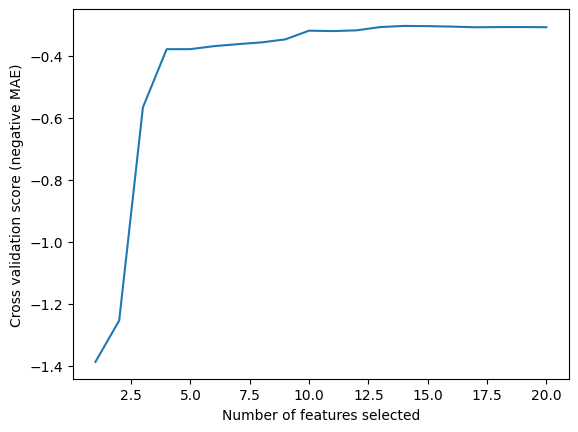

In [25]:

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (negative MAE)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()


In [26]:

#transform the model to use the best features
X_train_transformed_rfe = rfecv.transform(X_train_transformed)
X_test_transformed_rfe = rfecv.transform(X_test_transformed)

model.fit(X_train_transformed_rfe, y_train)

c:\Users\vivia\co-pilot-v1\myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:22:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "huber_slope" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.941599993761106, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.2794059456028195,
             grow_policy=None, huber_slope=0.2999415578976761,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.048035239601991755, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=5,
             max_depth=14, max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=620,
             n_jobs=None, num_parallel_tree=None, ...)

In [27]:

#save the preprocessor and the model for application
preprocessor_path = r"C:\Users\vivia\co-pilot-v1\Dashboard\Models\demand_predictor\preprocessor.joblib"
model_path = r"C:\Users\vivia\co-pilot-v1\Dashboard\Models\demand_predictor\xgb_regressor_with_selected_features.joblib"
dump(preprocessor, preprocessor_path)
dump(model, model_path)
y_pred = model.predict(X_test_transformed_rfe)

In [28]:

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\nModel Performance')
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R² Score: {r2}")



Model Performance
Test MSE: 34.9175461162728
Test RMSE: 5.9091070489772655
Test MAE: 0.28354899625609165
Test R² Score: 0.6721317172050476


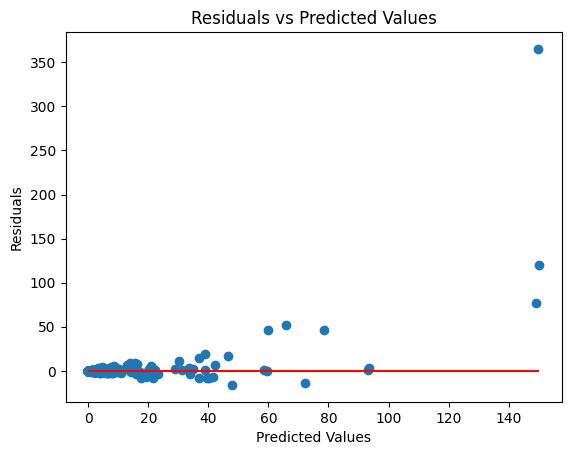

In [29]:

# Plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


In [31]:
# Load the hyperparameters from the JSON file
with open(general_model_path, 'r') as file:
    hyperparameters = json.load(file)

# Print the hyperparameters
print("Hyperparameters saved in the JSON file:")
print(hyperparameters)

Hyperparameters saved in the JSON file:
{'selected_features': ['months_no_sale', 'rolling_3_month_sales', 'cost_per_unit', 'total_cost', 'margin_percentage', 'gross_profit', 'roi', 'annual_days_supply', 'three_month_days_supply', 'annual_turnover', 'three_month_turnover', 'seasonal_component', 'safety_stock', 'reorder_point'], 'best_hyperparameters': {'colsample_bytree': 0.941599993761106, 'gamma': 0.2794059456028195, 'huber_slope': 0.2999415578976761, 'learning_rate': 0.048035239601991755, 'max_delta_step': 5, 'max_depth': 14, 'min_child_weight': 3, 'n_estimators': 620, 'reg_alpha': 0.005248444802271943, 'reg_lambda': 1.4151121870839436, 'subsample': 0.9289372561562756}}


In [33]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Load the data
df = pd.read_feather(dataset_path)

# Select the features (X) and target (y) for modeling
feature_cols = [col for col in df.columns if col not in {'part_number', 'description', 'supplier_name',
                                                         'sales_last_jan','sales_last_feb', 'sales_last_mar', 'sales_last_apr', 'sales_last_may',
                                                         'sales_last_jun', 'sales_last_jul', 'sales_last_aug', 'sales_last_sep',
                                                         'sales_last_oct', 'sales_last_nov', 'sales_last_dec', 'sales_jan',
                                                         'sales_feb', 'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 
                                                         'sales_jul', 'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 
                                                         'sales_dec', 'sales_this_year', 'sales_last_year', 'sales_revenue', 'quantity',
                                                         'price', 'sales_to_stock_ratio', 'rolling_12_month_sales', 'cogs', 'margin'}]
X = df[feature_cols]

# Add a constant to the DataFrame
df = sm.add_constant(X)

# Replace inf values with NaNs and then drop rows with NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

# Display the VIF for each feature
print(vif_data)


c:\Users\vivia\co-pilot-v1\myenv\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                    feature         VIF
0                     const   13.164129
1            months_no_sale    1.242215
2      quantity_ordered_ytd    1.455987
3        special_orders_ytd    1.053003
4          negative_on_hand    1.039370
5     rolling_3_month_sales    2.564270
6             cost_per_unit    1.684330
7                total_cost    1.586182
8         margin_percentage    1.143833
9              gross_profit    2.476194
10                      roi    1.016676
11       annual_days_supply    1.090553
12  three_month_days_supply    1.184167
13    one_month_days_supply         NaN
14          annual_turnover    1.659944
15     three_month_turnover    1.525770
16       one_month_turnover         NaN
17     order_to_sales_ratio    1.403856
18       seasonal_component   30.112468
19                   demand    1.974248
20             safety_stock  146.342886
21            reorder_point  141.734028
